# (1) Preprocessing Dataset

Make sure dataset file are in correct location.
run preprocess.py

In [1]:
from data.LDA import preprocess_text
from train.saving import save_model_results
from model.mf import MF_Bias, LDANet
from model.utility import RMSELoss

import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import gc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from train.saving import save_model_results
from skorch import NeuralNetRegressor

In [3]:
subsets = {
        "reviews_Toys_and_Games_5.json",
        "reviews_Apps_for_Android_5.json",
        "reviews_Health_and_Personal_Care_5.json",
    }
pth = os.getcwd()[:-4]
NUM_TOPICS = 10
preprocess_text(dataset=subsets, pth=pth, n_topics=NUM_TOPICS)
print(pth)

/Users/jb/Documents/GitHub/Intro ML (Nick Pang) Repository/rl-recommender


In [4]:
TG5_df = pd.read_json(os.path.join(pth, "datasets", "raw","reviews_Toys_and_Games_5.json"), lines=True)
AA5_df = pd.read_json(os.path.join(pth, "datasets", "raw", "reviews_Apps_for_Android_5.json"), lines=True)
HPC_df = pd.read_json(os.path.join(pth, "datasets", "raw", "reviews_Health_and_Personal_Care_5.json"), lines=True)

df = pd.concat([TG5_df, AA5_df, HPC_df], axis=0)
del TG5_df, AA5_df, HPC_df

# Keep essentials only
df = df[['reviewerID', 'asin', 'overall']]
print(df)

            reviewerID        asin  overall
0       A1VXOAVRGKGEAK  0439893577        5
1        A8R62G708TSCM  0439893577        4
2       A21KH420DK0ICA  0439893577        5
3        AR29QK6HPFYZ4  0439893577        5
4        ACCH8EOML6FN5  0439893577        4
...                ...         ...      ...
346350  A11J1FHCK5U06J  B00LJBMCKK        5
346351   AFVKI7BCS3FSX  B00LJBMCKK        5
346352  A1Y3FEUELH3FTI  B00LJBMCKK        5
346353  A11LC938XF35XN  B00LJBMCKK        5
346354  A2I8KUDXTC9WYI  B00LJBMCKK        5

[1266889 rows x 3 columns]


In [7]:
# Map values
user_dict = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "user_mappings.csv"))
item_dict = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "item_mappings.csv"))
user_dict = dict(zip(user_dict.iloc[:, 1], user_dict.index))
item_dict = dict(zip(item_dict.iloc[:, 1], item_dict.index))

df['reviewerID'] = df['reviewerID'].map(user_dict).fillna(df['reviewerID'])
df['asin'] = df['asin'].map(item_dict).fillna(df['asin'])

df[['reviewerID', 'asin']] = df[['reviewerID', 'asin']].astype(int)
df['overall'] = df['overall'].astype(float)

df = df.sort_values(by=['reviewerID', 'asin'], ignore_index=True)

print(df)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jb/Documents/GitHub/Intro ML (Nick Pang) Repository/rl-recommender/datasets/processed/lda/user_mappings.csv'

In [ ]:
m = df['overall'].mean()
np.savez_compressed(os.path.join(pth, "datasets", "processed", "Subset_5core_PreprocessLDA.npz"),
                    x = df[['reviewerID', 'asin']],
                    y = df['overall'],
                    u_size = len(user_dict),
                    i_size = len(item_dict),
                    m = m)

# (2) Create Model

This model doesn't use internal LDA YET!

### I wanted to test running on Apple Silicon Chips

In [ ]:
device = torch.device('mps' if torch.has_mps else 'cpu')
f_type = torch.float32 if device.type == 'mps' else torch.float64
print(f"device_type: {device}")
print(f"float_type: {f_type}")


max_v = max(df['reviewerID'].max(), df['asin'].max())
min_v = max(df['reviewerID'].min(), df['asin'].min())
print(f"max value: {max_v}\nmin value: {min_v}")

if 0 <= min_v <= 255 and 0 <= max_v <= 255:
    int_type = torch.uint8
elif -128 <= min_v <= 127 and -128 <= max_v <= 127:
    int_type = torch.int8
elif -32768 <= min_v <= 32767 and -32768 <= max_v <= 32767:
    int_type = torch.int16
elif -2147483648 <= min_v <= 2147483647 and -2147483648 <= max_v <= 2147483647:
    int_type = torch.int32
else:
    int_type = torch.int64
print(f"int_type: {int_type}")

device_type: mps
float_type: torch.float32
max value: 139812
min value: 0
int_type: torch.int32


In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
EPOCHS = 15
DECAY = 1e-3
DROPOUT = 0.4

In [ ]:
gc.collect()

data = np.load(os.path.join(pth, "datasets", "processed", "Subset_5core_PreprocessLDA.npz"))
x = data['x']
y = data['y']
U_size = data['u_size']
I_size = data['i_size']
G_b = data['m']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

x_train, x_test = torch.tensor(x_train, dtype = int_type).to(device), torch.tensor(x_test, dtype = int_type).to(device) #Int because Embeddings layer
y_train, y_test = torch.tensor(y_train, dtype = f_type).to(device), torch.tensor(y_test, dtype = f_type).to(device)

loss_fn = RMSELoss()
optimizer = Adam

### I am adding the class here only so I append **.to(*device*)** for each tensor

In [ ]:
## nn.Embedding initialized to random -1 to 1

class MF(nn.Module):
    def __init__(self, n_users, n_items, K, dropout=0):
        super().__init__()
        self.user_m = nn.Embedding(
            n_users, K, dtype=f_type
        ).to(device)  # can include option sparse = True for memory
        self.item_m = nn.Embedding(n_items, K, dtype=f_type).to(device)
        self.drop_u = nn.Dropout(dropout)
        self.drop_i = nn.Dropout(dropout)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        user_embeds = self.drop_u(self.user_m(user_ids))
        item_embeds = self.drop_i(self.item_m(item_ids))
        prod = user_embeds * item_embeds

        out = torch.sum(prod, 1)

        return out


# Matrix factorization with user/item biases
class MF_Bias(MF):
    def __init__(self, n_users, n_items, K, G_b, dropout=0):
        super().__init__(n_users, n_items, K, dropout)

        self.user_b = nn.Embedding(n_users, 1, dtype=f_type).to(device)
        self.item_b = nn.Embedding(n_items, 1, dtype=f_type).to(device)
        nn.init.zeros_(self.user_b.weight)
        nn.init.zeros_(self.item_b.weight)

        self.G_b = torch.from_numpy(G_b)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        out = super().forward(x)

        user_biases = self.user_b(user_ids).squeeze()
        item_biases = self.item_b(item_ids).squeeze()

        out += user_biases + item_biases + self.G_b

        return out

In [6]:
model = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)

NameError: name 'U_size' is not defined

In [ ]:
# Since nn.Embedding initialized to random -1 to 1.
# Creating a mapping from row -> -1 to 1 

def row_mapping(l: list):
    min_v = float("inf")
    max_v = -float("inf")
    
    for v in l:
        if v > max_v:
            max_v = v
        if v < min_v:
            min_v = v
    
    return [((2 * (x - min_v)) / (max_v - min_v)) - 1 for x in l]

# example
print(row_mapping([
    0.0063068993260669,
    0.0063068993278832,
    0.0063068993273011,
    0.0063068993291702,
    0.0063068993316196,
    0.0063068993263096,
    0.0063068993281883,
    0.0063068993275349,
    0.3462632596023473,
    0.6032815457735784]))

[-1.0, -0.999999999993915, -0.9999999999958652, -0.9999999999896032, -0.9999999999813972, -0.9999999999991869, -0.9999999999928928, -0.9999999999950818, 0.13893064738778915, 1.0]


In [ ]:
user_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "user_topics.csv"))
for idx,row  in user_map.iterrows():
    row = row[1:] # to remove 'User_ID' from row
    row = row.tolist()
    row = row_mapping(row)
    model.user_m.weight.data[idx] = torch.tensor(row, dtype=f_type).to(device)

item_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "item_topics.csv"))
for idx,row  in item_map.iterrows():
    row = row[1:] # to remove 'Item_ID' from row
    row = row.tolist()
    row = row_mapping(row)
    model.item_m.weight.data[idx] = torch.tensor(row, dtype=f_type).to(device)

# (3) Run Model

In [ ]:
regressor = NeuralNetRegressor(
    model,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)
gc.collect()

0

### Borrowed from *save_model_results()*

In [ ]:
results = regressor.fit(x_train, y_train)
history = results.history

tr_losses = [i['train_loss'] for i in history]
t_losses = [i['valid_loss'] for i in history]

with open(os.path.join(pth, "results", f"User-Item-Model_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model, f)

np.savez_compressed(os.path.join(pth, "results", f"User-Item-Model_{device}_{f_type}.npz"),
                    tr_loss = tr_losses,
                    t_loss = t_losses)

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        1.7547        1.1975  140.7620
      2        1.1721        1.1673  140.0995
      3        1.1356        1.1504  135.5943
      4        1.1095        1.1395  135.4628
      5        1.0893        1.1321  141.5919
      6        1.0730        1.1269  137.5206
      7        1.0596        1.1232  128.6423
      8        1.0483        1.1206  123.2708
      9        1.0385        1.1188  130.8780
     10        1.0301        1.1176  129.2637
     11        1.0228        1.1168  128.0783
     12        1.0163        1.1164  128.1282
     13        1.0105        1.1163  127.3894
     14        1.0054        1.1164  128.7071
     15        1.0008        1.1166  129.8037


### Another Model without setting the weights

In [ ]:
model = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)

In [ ]:
regressor = NeuralNetRegressor(
    model,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)
gc.collect()

80

In [ ]:
results = regressor.fit(x_train, y_train)
history = results.history

tr_losses = [i['train_loss'] for i in history]
t_losses = [i['valid_loss'] for i in history]

with open(os.path.join(pth, "results", f"No-Adjustments-Model_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model, f)

np.savez_compressed(os.path.join(pth, "results", f"No-Adjustments-Model_{device}_{f_type}.npz"),
                    tr_loss = tr_losses,
                    t_loss = t_losses)

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        1.5791        1.1964  124.7829
      2        1.1723        1.1685  123.6220
      3        1.1366        1.1516  124.4638
      4        1.1104        1.1404  130.1095
      5        1.0901        1.1329  131.6274
      6        1.0737        1.1275  128.5890
      7        1.0602        1.1238  126.5420
      8        1.0488        1.1211  129.6380
      9        1.0390        1.1192  122.3929
     10        1.0305        1.1179  120.5147
     11        1.0231        1.1171  125.7623
     12        1.0166        1.1167  127.1980
     13        1.0108        1.1165  130.0109
     14        1.0057        1.1166  128.4058
     15        1.0010        1.1168  127.4115


### Only Preprocessed Users & Only Items

In [ ]:
model_users = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)
model_items = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)

In [ ]:
user_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "user_topics.csv"))
for idx,row  in user_map.iterrows():
    row = row[1:] # to remove 'User_ID' from row
    row = row.tolist()
    row = row_mapping(row)
    model_users.user_m.weight.data[idx] = torch.tensor(row, dtype=f_type).to(device)

item_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "item_topics.csv"))
for idx,row  in item_map.iterrows():
    row = row[1:] # to remove 'Item_ID' from row
    row = row.tolist()
    row = row_mapping(row)
    model_items.item_m.weight.data[idx] = torch.tensor(row, dtype=f_type).to(device)

In [ ]:
regressor_users = NeuralNetRegressor(
    model_users,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)
regressor_items = NeuralNetRegressor(
    model_items,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)

In [ ]:
results = regressor_users.fit(x_train, y_train)
history = results.history

tr_losses = [i['train_loss'] for i in history]
t_losses = [i['valid_loss'] for i in history]

with open(os.path.join(pth, "results", f"Users-Only-Model_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model, f)

np.savez_compressed(os.path.join(pth, "results", f"Users-Only-Model_{device}_{f_type}.npz"),
                    tr_loss = tr_losses,
                    t_loss = t_losses)

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        1.4857        1.1964  122.9196
      2        1.1723        1.1684  124.7514
      3        1.1366        1.1515  125.4744
      4        1.1104        1.1404  123.9409
      5        1.0900        1.1328  126.2772
      6        1.0736        1.1275  134.4627
      7        1.0601        1.1237  133.5554
      8        1.0487        1.1211  132.6427
      9        1.0389        1.1192  319.8989
     10        1.0305        1.1179  199.9734
     11        1.0231        1.1171  131.4850
     12        1.0166        1.1167  126.8075
     13        1.0108        1.1165  123.5725
     14        1.0056        1.1166  117.8355
     15        1.0010        1.1168  123.4400


In [ ]:
results = regressor_items.fit(x_train, y_train)
history = results.history

tr_losses = [i['train_loss'] for i in history]
t_losses = [i['valid_loss'] for i in history]

with open(os.path.join(pth, "results", f"Items-Only-Model_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model, f)

np.savez_compressed(os.path.join(pth, "results", f"Items-Only-Model_{device}_{f_type}.npz"),
                    tr_loss = tr_losses,
                    t_loss = t_losses)

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        1.5360        1.1964  125.1076
      2        1.1724        1.1685  124.1936
      3        1.1367        1.1516  123.8268
      4        1.1105        1.1405  122.7363
      5        1.0902        1.1329  123.8214
      6        1.0738        1.1275  124.9589
      7        1.0602        1.1238  120.4494
      8        1.0488        1.1211  121.4622
      9        1.0390        1.1192  120.7920
     10        1.0306        1.1179  123.8679
     11        1.0232        1.1171  122.6067
     12        1.0166        1.1167  118.7725
     13        1.0108        1.1165  117.8177
     14        1.0057        1.1166  118.7095
     15        1.0010        1.1168  122.4903


# (4) Graphs

In [ ]:
gc.collect()

0

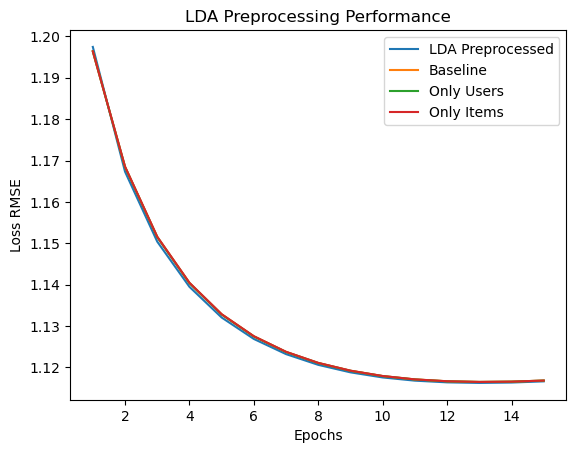

In [ ]:
import matplotlib.pyplot as plt
p = np.load(os.path.join(pth, "results", f"User-Item-Model_{device}_{f_type}.npz"))
not_p = np.load(os.path.join(pth, "results", f"No-Adjustments-Model_{device}_{f_type}.npz"))
u = np.load(os.path.join(pth, "results", f"Users-Only-Model_{device}_{f_type}.npz"))
i = np.load(os.path.join(pth, "results", f"Items-Only-Model_{device}_{f_type}.npz"))

plt.plot([i+1 for i in range(EPOCHS)], p['t_loss'], label='LDA Preprocessed')
plt.plot([i+1 for i in range(EPOCHS)], not_p['t_loss'], label='Baseline')
plt.plot([i+1 for i in range(EPOCHS)], u['t_loss'], label='Only Users')
plt.plot([i+1 for i in range(EPOCHS)], i['t_loss'], label='Only Items')
plt.xlabel('Epochs')
plt.ylabel('Loss RMSE')
plt.title('LDA Preprocessing Performance')
plt.legend()
plt.show()

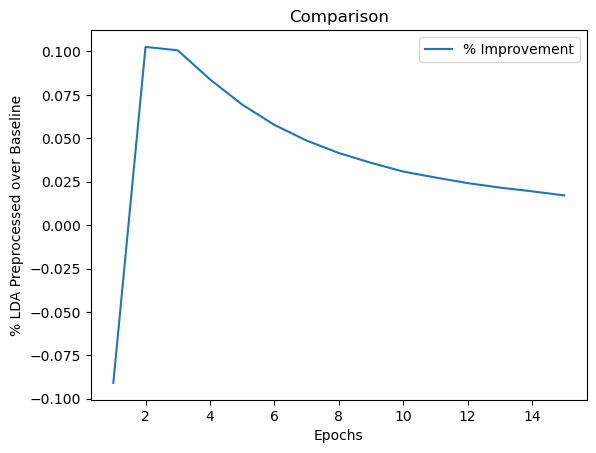

In [ ]:
factor = list()
for i in range(len(p['t_loss'])):
    f = (100 *(float(not_p['t_loss'][i]) / float(p['t_loss'][i]))) - 100
    factor.append(f)

plt.plot([i+1 for i in range(EPOCHS)], factor, label='% Improvement')
plt.xlabel('Epochs')
plt.ylabel('% LDA Preprocessed over Baseline')
plt.title('Comparison')
plt.legend()
plt.show()